<a href="https://colab.research.google.com/github/swastikbanerjee/DL_Lab/blob/main/dlLab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2

def resize_frames(input_folder, output_folder, target_size):
    for frame_file in os.listdir(input_folder):
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        if frame is None:
            print("Error: Unable to read the frame. Check if the frame is empty.")
            continue
        resized_frame = cv2.resize(frame, target_size)
        output_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(output_path, resized_frame)
input_frames_folder = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images'
output_resized_frames_folder = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_resized'
target_size = (640, 640)
resize_frames(input_frames_folder, output_resized_frames_folder, target_size)


In [ ]:
import cv2
import os
def normalize_resized_frames(input_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    frame_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        normalized_frame = frame / 255.0
        output_path = os.path.join(output_folder, frame_file)
        cv2.imwrite(output_path, normalized_frame * 255.0)
resized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_resized'
normalized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_normalized'
normalize_resized_frames(resized_frames_folder_path, normalized_frames_folder_path)

In [ ]:
import cv2
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def augment_frames(input_folder, output_folder, augmentations_per_image=3):
    os.makedirs(output_folder, exist_ok=True)
    frame_files = [f for f in os.listdir(input_folder) if f.endswith('.jpg')]
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )
    for frame_file in frame_files:
        frame_path = os.path.join(input_folder, frame_file)
        frame = cv2.imread(frame_path)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = frame.reshape((1,) + frame.shape)
        for i, batch in enumerate(datagen.flow(frame, batch_size=1, save_to_dir=output_folder, save_prefix=f"{frame_file[:-4]}_aug", save_format='jpg')):
            if i >= augmentations_per_image:
                break
resized_normalized_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_normalized'
augmented_frames_folder_path = r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\images_augmented_less'
augment_frames(resized_normalized_frames_folder_path, augmented_frames_folder_path)


0: 640x640 1 person, 1 motorcycle, 416.1ms
Speed: 15.6ms preprocess, 416.1ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)
Confidence ---> 0.79
Class name --> bus
Confidence ---> 0.65
Class name --> Unknown


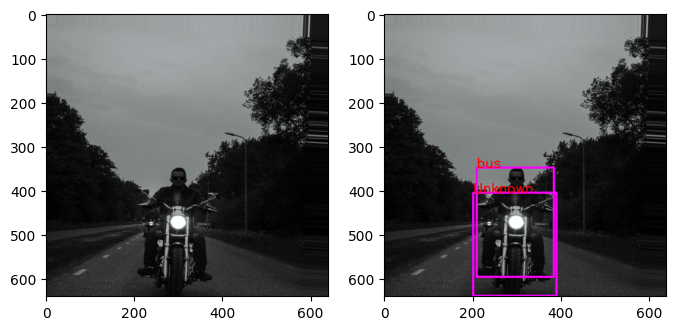

In [ ]:
import cv2
import math
import yaml
from ultralytics import YOLO
import matplotlib.pyplot as plt

with open("vehicles.yaml", "r") as file:
    config = yaml.safe_load(file)

img = cv2.imread(r'C:\Users\rickyswas\OneDrive\Desktop\CNNs\dataset_lab8\test\pexels-bas-masseus-1253639_aug_0_8917.jpg')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,8))
ax[0].imshow(img)
model = YOLO("yolov8n.pt")
classNames = config['names']
results = model(img)
for r in results:
    boxes = r.boxes

    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 255), 3)
        confidence = math.ceil((box.conf[0] * 100)) / 100
        print("Confidence --->", confidence)
        cls = int(box.cls[0])
        class_name = classNames[cls] if 0 <= cls < len(classNames) else "Unknown"
        print("Class name -->", class_name)
        org = [x1, y1]
        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1
        color = (255, 0, 0)
        thickness = 2
        cv2.putText(img, class_name, org, font, fontScale, color, thickness)
ax[1].imshow(img)

In [ ]:
import numpy as np
ground_truth_boxes = np.array([
    [0.500000, 0.688053, 0.300885, 0.247788, 0],
    [0.359513, 0.684735, 0.272124, 0.121681, 1],
    [0.455752, 0.265487, 0.314159, 0.517699, 2],
])
predicted_boxes = np.array([
    [0.629425, 0.405973, 0.245575, 0.170354, 0.9, 0],
    [0.544248, 0.474558, 0.411504, 0.546460, 0.8, 1],
    [0.463496, 0.769912, 0.307522, 0.451327, 0.7, 2],
])
def calculate_iou(gt, pred):
    x1_int = max(gt[0], pred[0])
    y1_int = max(gt[1], pred[1])
    x2_int = min(gt[2], pred[2])
    y2_int = min(gt[3], pred[3])
    intersection_area = max(0, x2_int - x1_int + 1) * max(0, y2_int - y1_int + 1)
    gt_area = (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1)
    pred_area = (pred[2] - pred[0] + 1) * (pred[3] - pred[1] + 1)
    union_area = gt_area + pred_area - intersection_area
    iou = intersection_area / union_area
    return iou
total_iou = 0
total_giou = 0
total_ap = 0
for gt_box in ground_truth_boxes:
    ious = []
    for pred_box in predicted_boxes:
        if gt_box[4] != pred_box[5]:
            iou = 0
        else:
            iou = calculate_iou(gt_box[:4], pred_box[:4])
            x1_int = max(gt_box[0], pred_box[0])
            y1_int = max(gt_box[1], pred_box[1])
            x2_int = min(gt_box[2], pred_box[2])
            y2_int = min(gt_box[3], pred_box[3])
            intersection_area = max(0, x2_int - x1_int + 1) * max(0, y2_int - y1_int + 1)
            gt_area = (gt_box[2] - gt_box[0] + 1) * (gt_box[3] - gt_box[1] + 1)
            pred_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
            union_area = gt_area + pred_area - intersection_area
        ious.append(iou)
    max_iou = max(ious) if ious else 0
    total_iou += max_iou
    if max_iou > 0:
        pred_box = predicted_boxes[np.argmax(ious)]
        giou = calculate_iou(gt_box[:4], pred_box[:4])
        x1_enclose = min(gt_box[0], pred_box[0])
        y1_enclose = min(gt_box[1], pred_box[1])
        x2_enclose = max(gt_box[2], pred_box[2])
        y2_enclose = max(gt_box[3], pred_box[3])
        enclose_area = max(1e-16, (x2_enclose - x1_enclose + 1) * (y2_enclose - y1_enclose + 1))
        giou = giou - ((enclose_area - union_area) / enclose_area)
        total_giou += giou
    ap = total_iou / len(ground_truth_boxes)
    total_ap += ap
mAP = total_ap / len(ground_truth_boxes)
mIoU = total_iou / len(ground_truth_boxes)
mGIoU = total_giou / len(ground_truth_boxes)

print("Mean Average Precision (mAP):", mAP)
print("Mean Intersection over Union (mIoU):", mIoU)
print("Mean Generalized Intersection over Union (mGIoU):", mGIoU)

Mean Average Precision (mAP): 0.28863628920790274
Mean Intersection over Union (mIoU): 0.44251350059998695
Mean Generalized Intersection over Union (mGIoU): 0.38207545297129436


Mean Average Precision (mAP): Average Precision (AP) is a popular metric in object detection. It measures the average of precision values at different recall levels. Precision is the ratio of true positive predictions to the total number of predicted positives.
In this script, we are calculating AP for each ground truth box, then taking the average across all ground truth boxes to get mAP.

Mean Intersection over Union (mIoU): Intersection over Union (IoU) measures the overlap between the predicted bounding box and the ground truth box. It's calculated as the area of overlap between the two boxes divided by the area of union.
mIoU is the average of IoU values calculated for each pair of predicted and ground truth boxes.

Mean Generalized Intersection over Union (mGIoU): Generalized IoU (GIoU) is an improvement over IoU that also considers the bounding box shapes when computing the overlap.
mGIoU is the average of GIoU values calculated for each pair of predicted and ground truth boxes.

In [ ]:
def non_max_suppression(boxes, scores, iou_threshold):
    sorted_indices = np.argsort(scores)[::-1]
    keep_indices = []
    while len(sorted_indices) > 0:
        max_index = sorted_indices[0]
        keep_indices.append(max_index)
        ious = np.array([calculate_iou(boxes[max_index], boxes[idx]) for idx in sorted_indices[1:]])
        indices_to_keep = np.where(ious <= iou_threshold)[0]
        sorted_indices = sorted_indices[indices_to_keep + 1]
    return keep_indices

Non-Maximum Suppression (NMS) is a technique commonly used in object detection to reduce redundant and overlapping bounding boxes predicted by an algorithm. The main goal of NMS is to clean up the bounding box outputs so that for each object in the image, we ideally have just one bounding box that best encapsulates that object.

Purpose of Non-Maximum Suppression:
Removing Redundancy: When an object is detected, the object detection model might predict multiple bounding boxes that cover the same object or region.

Selecting the Best Box: NMS helps in selecting the most confident and accurate bounding box for each object by suppressing (removing) the redundant and less confident boxes.